In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KernelDensity

In [3]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=Warning)

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Automobile%20Insurance/insurance_claims.csv")

In [5]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 40 columns


In [6]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [7]:
df = df.drop(columns=[
                      'policy_number', '_c39', 'property_claim', 'injury_claim', 
                      'vehicle_claim', 'policy_bind_date','insured_zip','incident_date',
                      'incident_location'
                      ])

In [8]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 31 columns


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   object 
 3   policy_csl                   1000 non-null   object 
 4   policy_deductable            1000 non-null   int64  
 5   policy_annual_premium        1000 non-null   float64
 6   umbrella_limit               1000 non-null   int64  
 7   insured_sex                  1000 non-null   object 
 8   insured_education_level      1000 non-null   object 
 9   insured_occupation           1000 non-null   object 
 10  insured_hobbies              1000 non-null   object 
 11  insured_relationship         1000 non-null   object 
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

In [10]:
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for Dataset', fontsize=15)
    plt.show()

In [11]:
def plotPerColumnDistribution(df, y, nGraphShown, nGraphPerRow, typ):
    ds = pd.concat([df, y], axis=1)
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        columnName = df.columns[i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            if typ == 'hist':
              sns.histplot(x=columnName, data=ds)
            if typ == 'violin':
              sns.violinplot(x=columnName, y='total_claim_amount', data=ds)
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1, w_pad = 1, h_pad = 1)
    plt.show()

In [12]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [13]:
def plotHistogram(data):
  sns.distplot(data, hist=True, kde=True, 
              bins=100, color = 'darkblue', 
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 4}, )

In [14]:
numericals = df.select_dtypes(include=np.number).columns.tolist()
categoricals = df.select_dtypes(include='object').columns.tolist()
print(len(numericals)+len(categoricals))

31


In [15]:
df[categoricals].describe(include=np.object)

,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,property_damage,police_report_available,auto_make,auto_model,fraud_reported
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,3,3,2,7,14,20,6,4,4,4,5,7,7,3,3,14,39,2
top,OH,250/500,FEMALE,JD,machine-op-inspct,reading,own-child,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Springfield,?,?,Saab,RAM,N
freq,352,351,537,161,93,64,183,419,292,354,292,262,157,360,343,80,43,753


In [16]:
df = df.replace('?','NA')

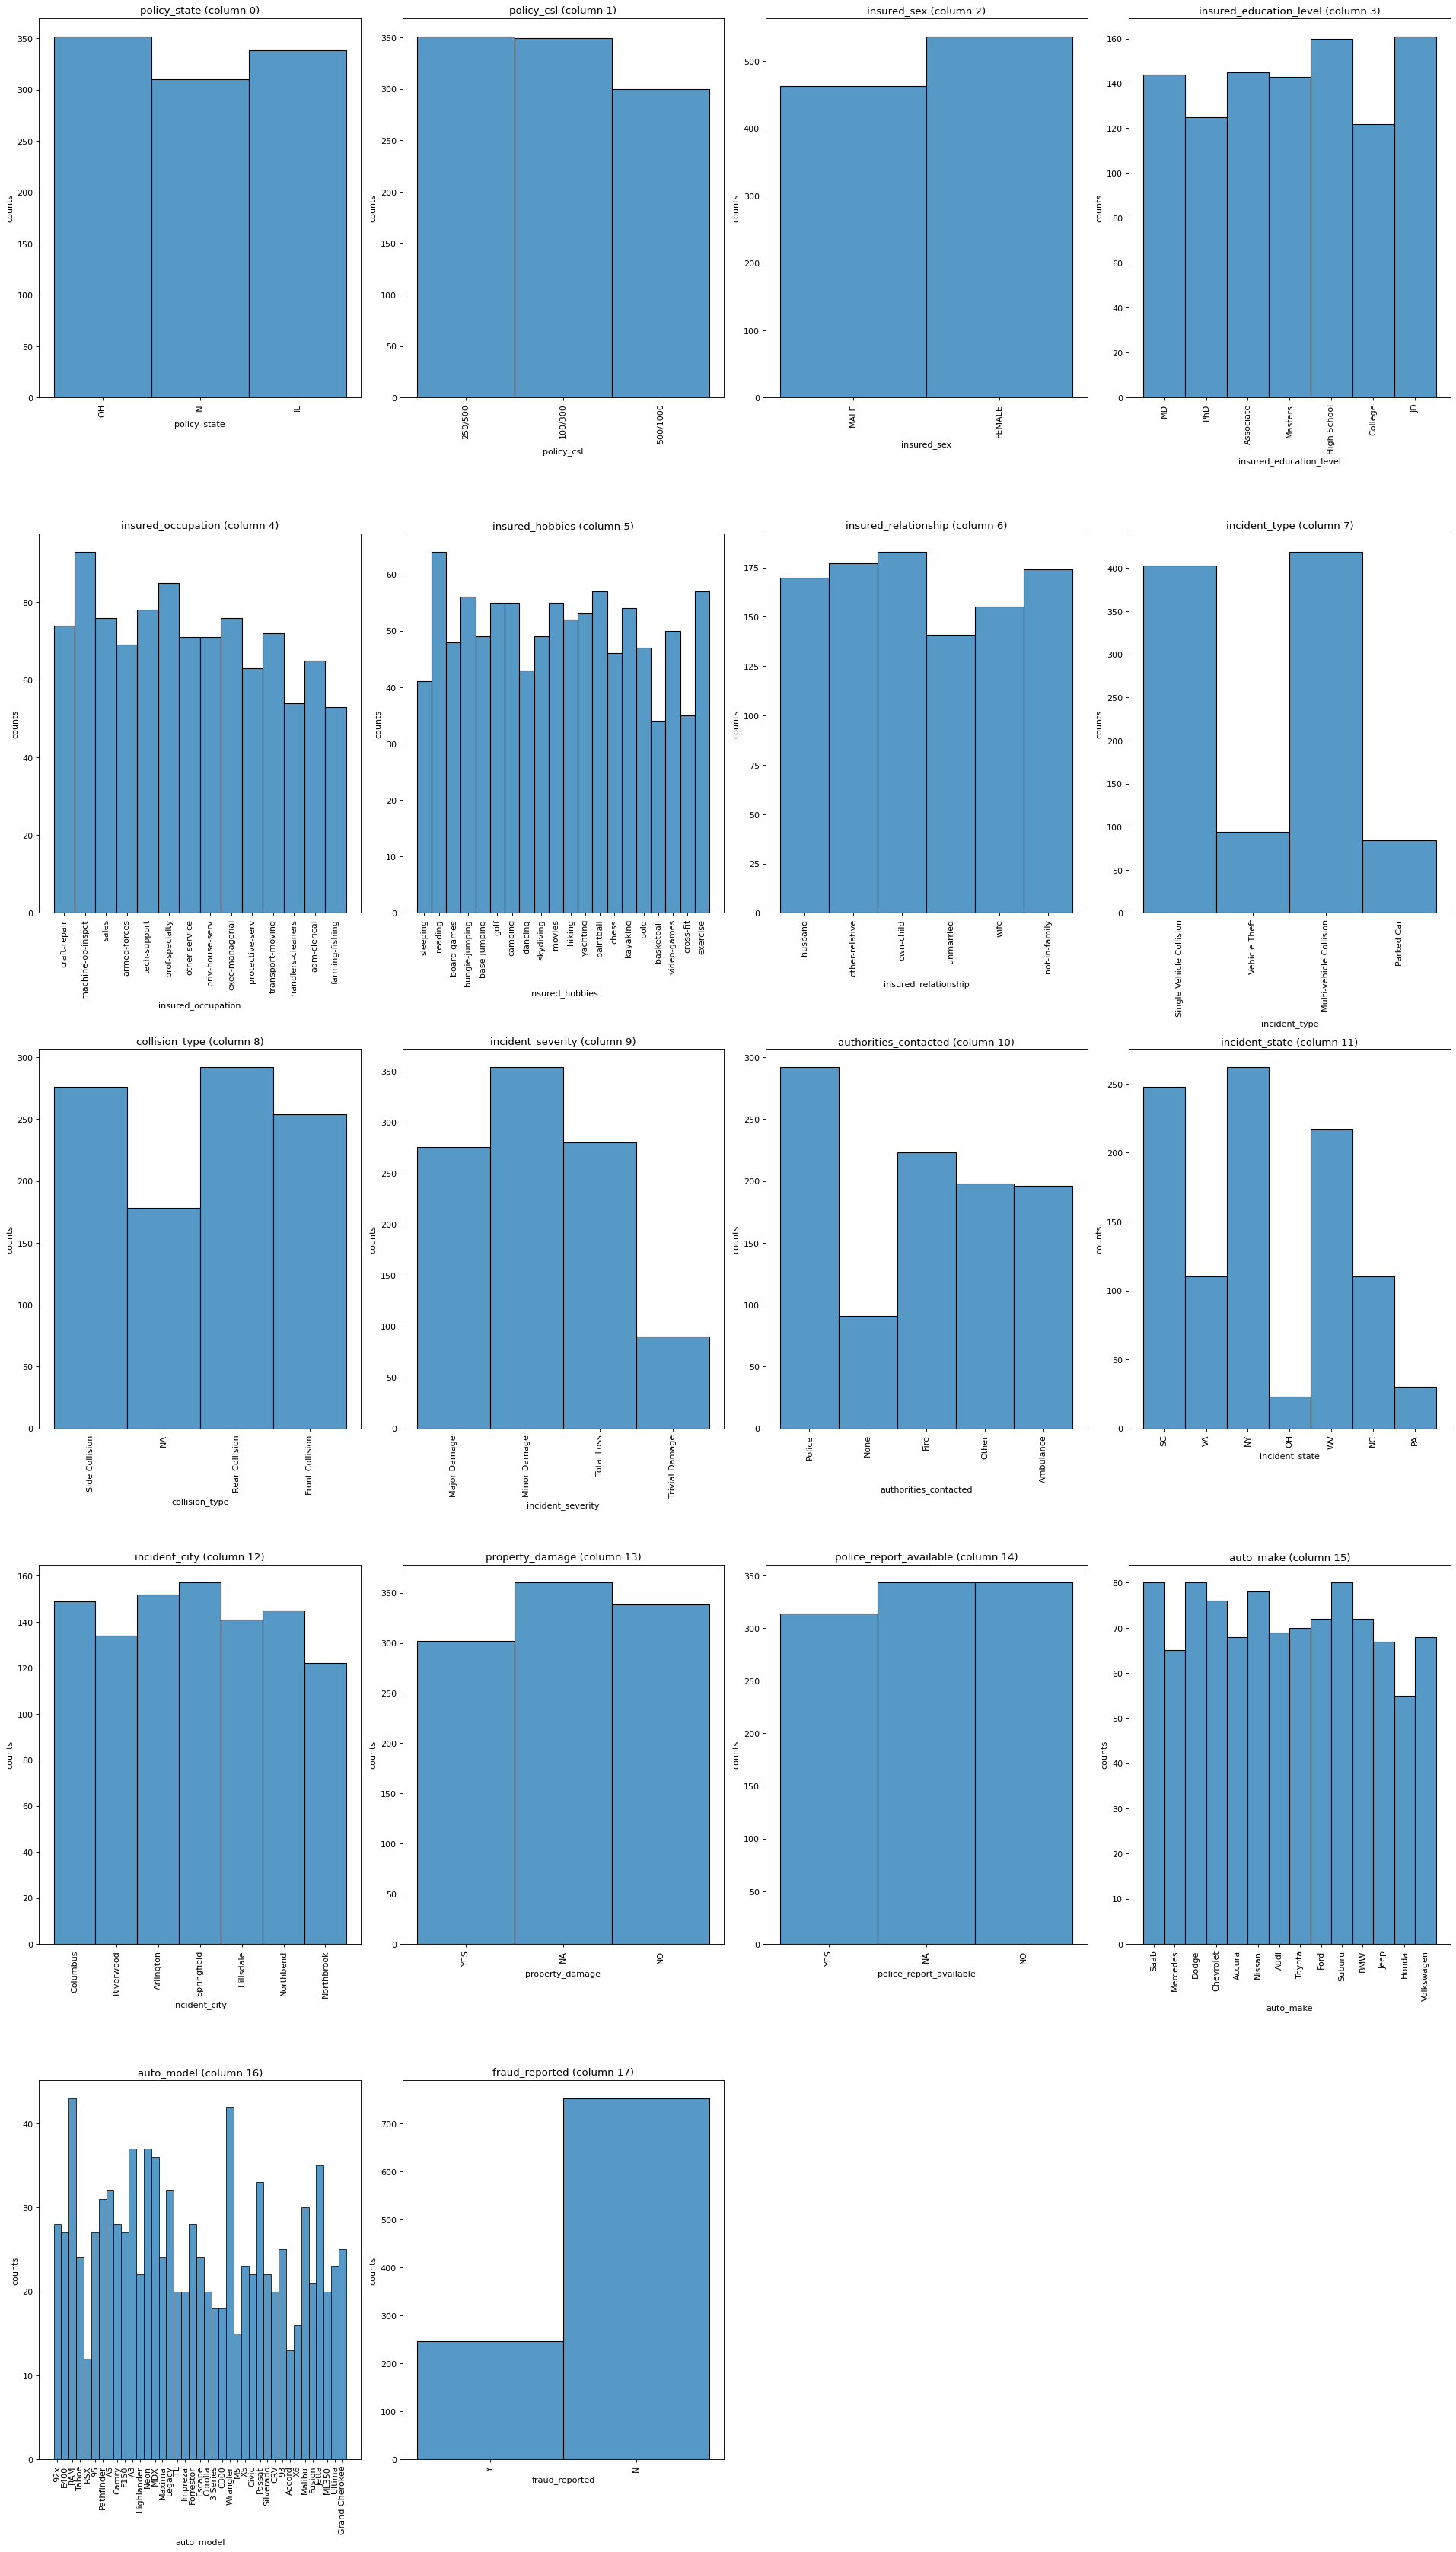

In [17]:
plotPerColumnDistribution(df[categoricals], df['total_claim_amount'], len(df[categoricals]), 4, 'hist')

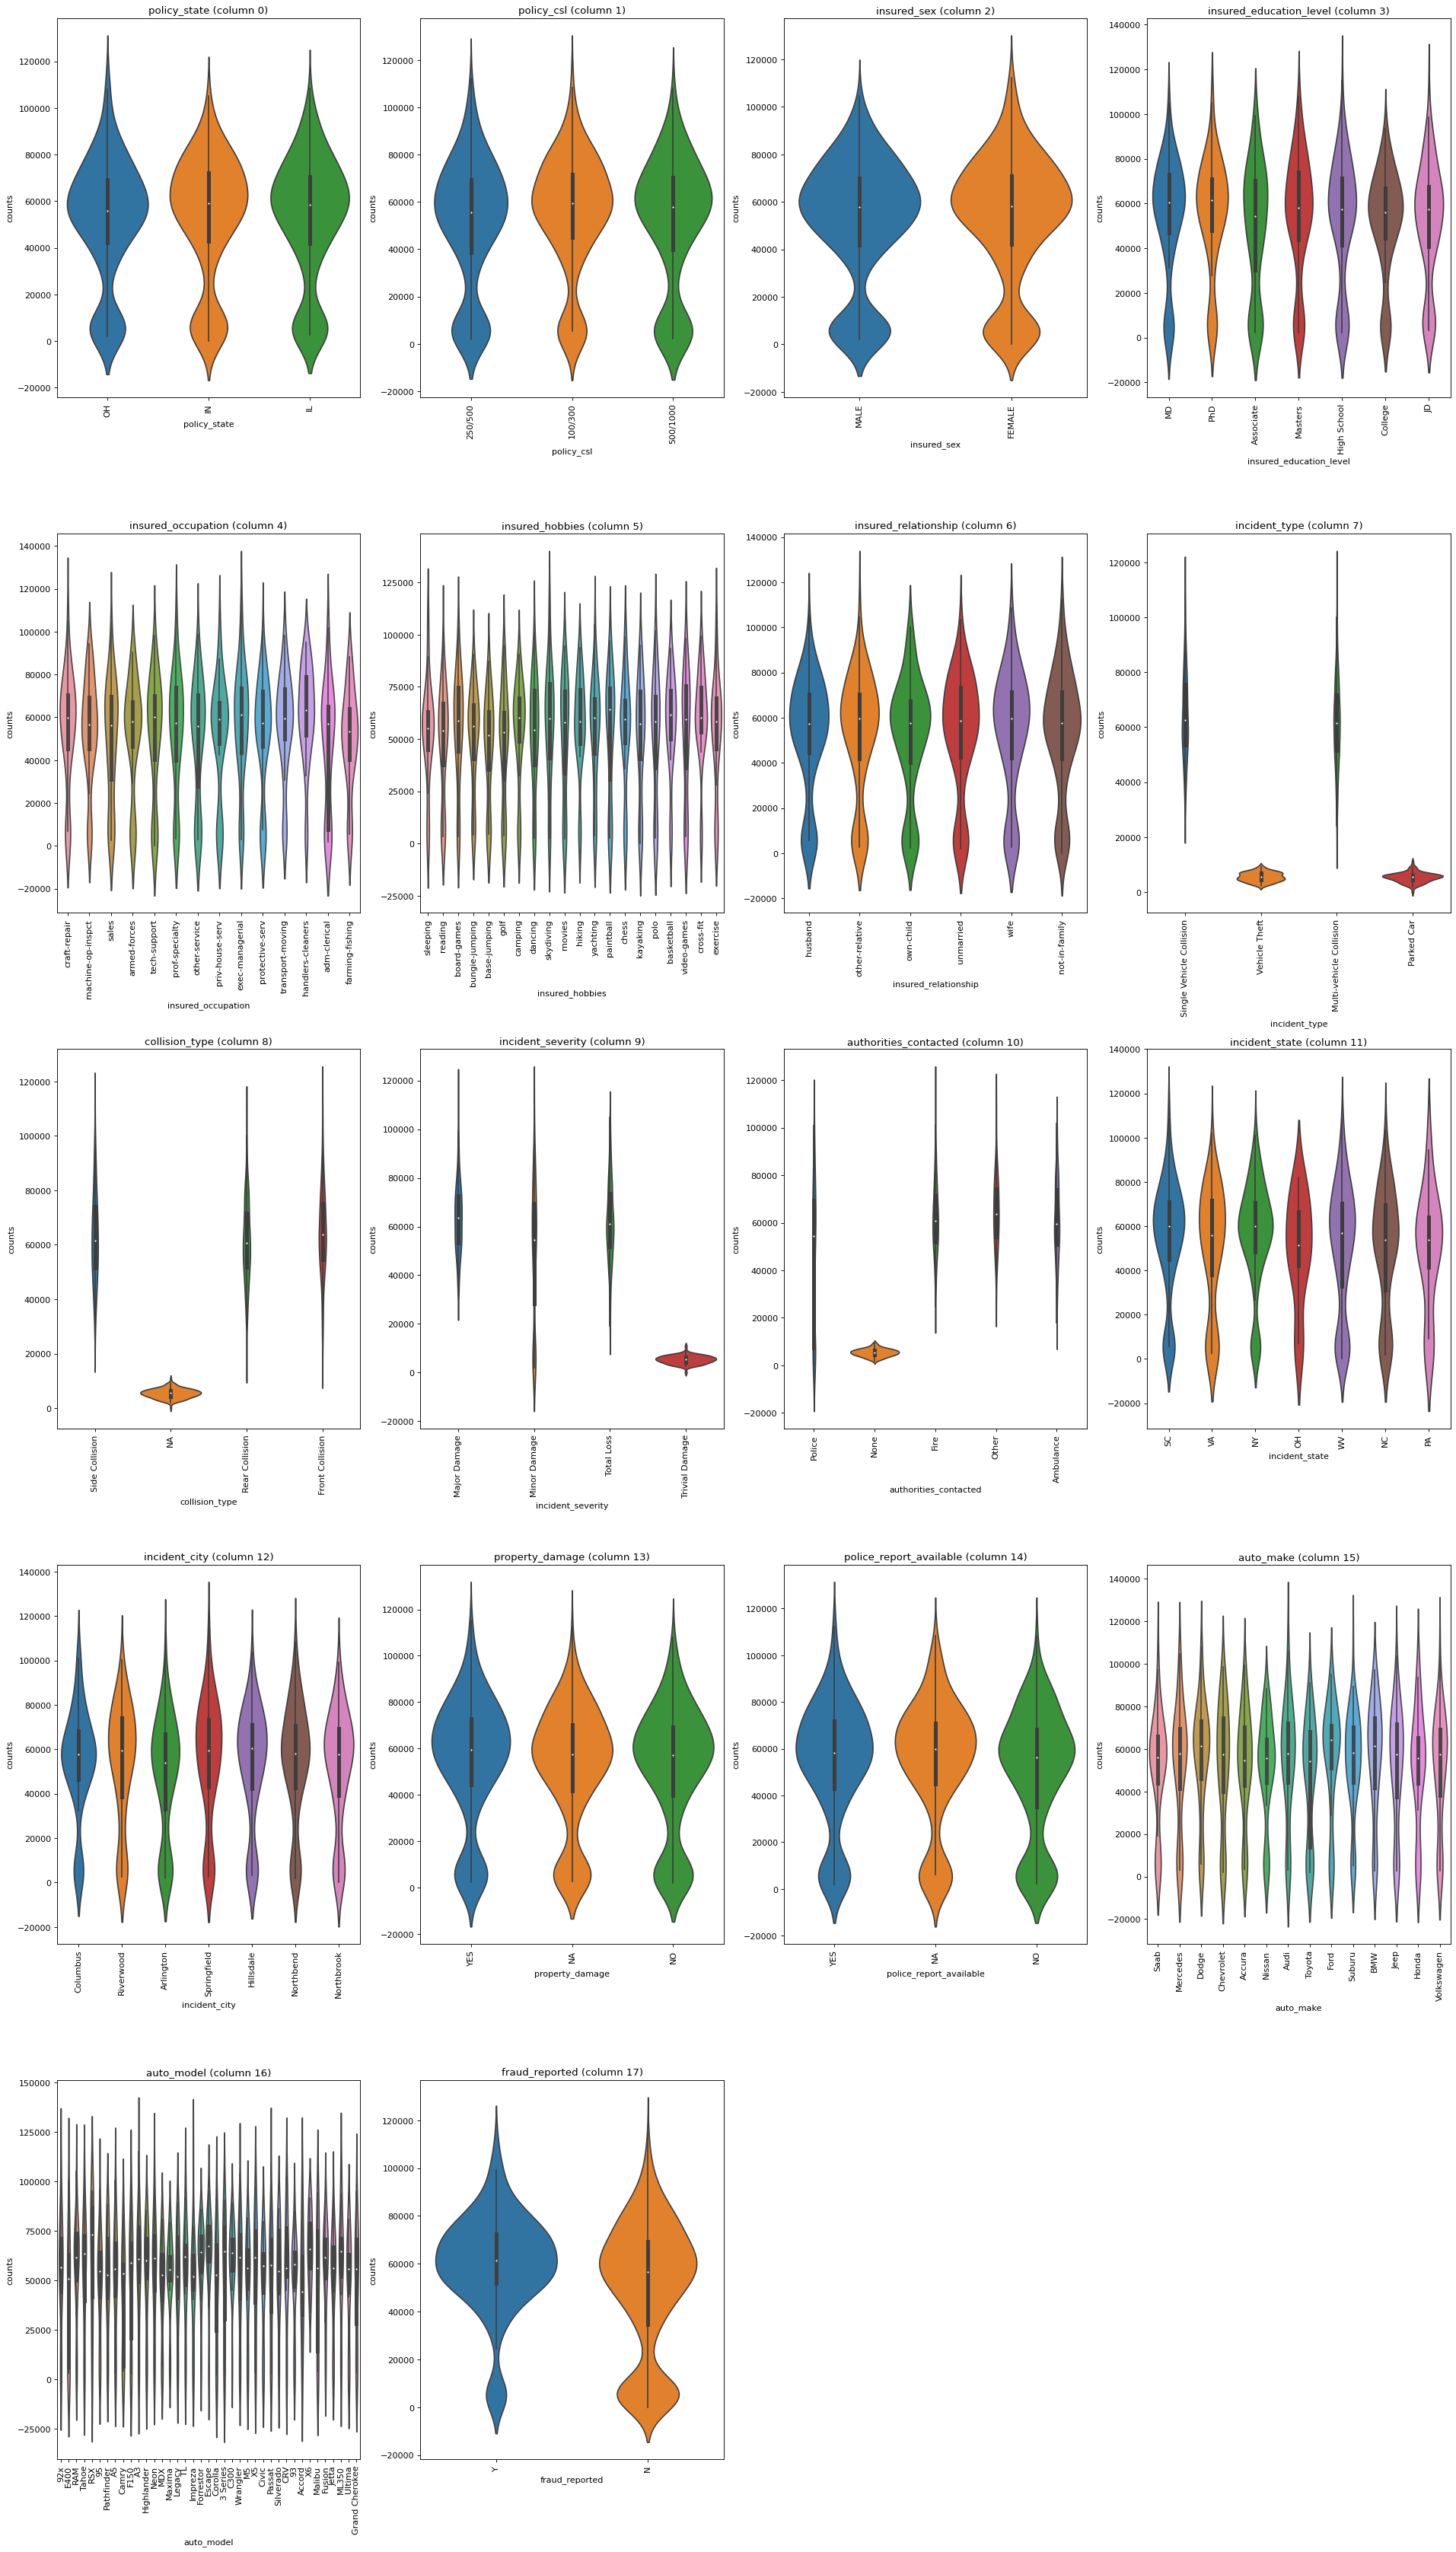

In [18]:
plotPerColumnDistribution(df[categoricals], df['total_claim_amount'], len(df[categoricals]), 4, 'violin')

In [19]:
csl = {
    '100/300':1, 
    '250/500':2, 
    '500/1000':3
    }
df['policy_csl'] = df['policy_csl'].replace(csl)

In [20]:
edu = {
       'JD': 21,
       'High School': 12,
       'Associate': 14,
       'MD': 21,
       'Masters': 18,
       'PhD': 21,
       'College': 16,
       }
df['insured_education_level'] = df['insured_education_level'].replace(edu)
df['insured_education_level'].value_counts()

21    430
12    160
14    145
18    143
16    122
Name: insured_education_level, dtype: int64

In [21]:
df['incident_type'] = df['incident_type'].replace(['Parked Car','Vehicle Theft'], 1)
df['incident_type'] = df['incident_type'].replace(['Single Vehicle Collision','Multi-vehicle Collision'], 2)
df['incident_type'].value_counts()

2    822
1    178
Name: incident_type, dtype: int64

In [22]:
df = df.replace('NAN', 'Unknown')
df.dtypes

months_as_customer               int64
age                              int64
policy_state                    object
policy_csl                       int64
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_sex                     object
insured_education_level          int64
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_type                    int64
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage                 object
bodily_injuries                  int64
witnesses                        int64
police_report_available  

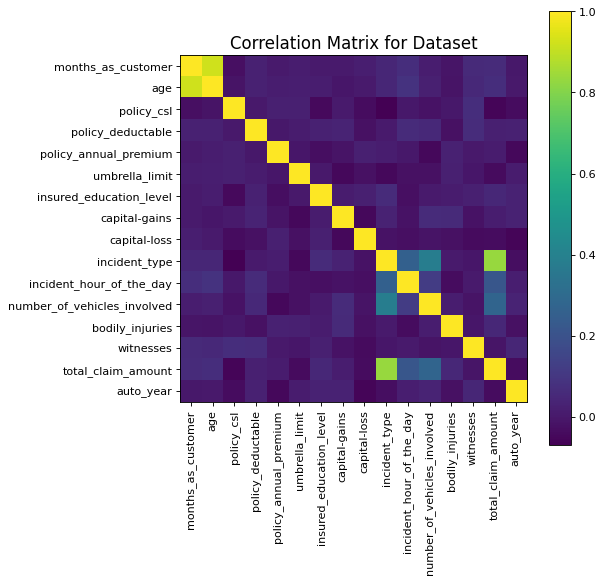

In [23]:
plotCorrelationMatrix(df, 7)

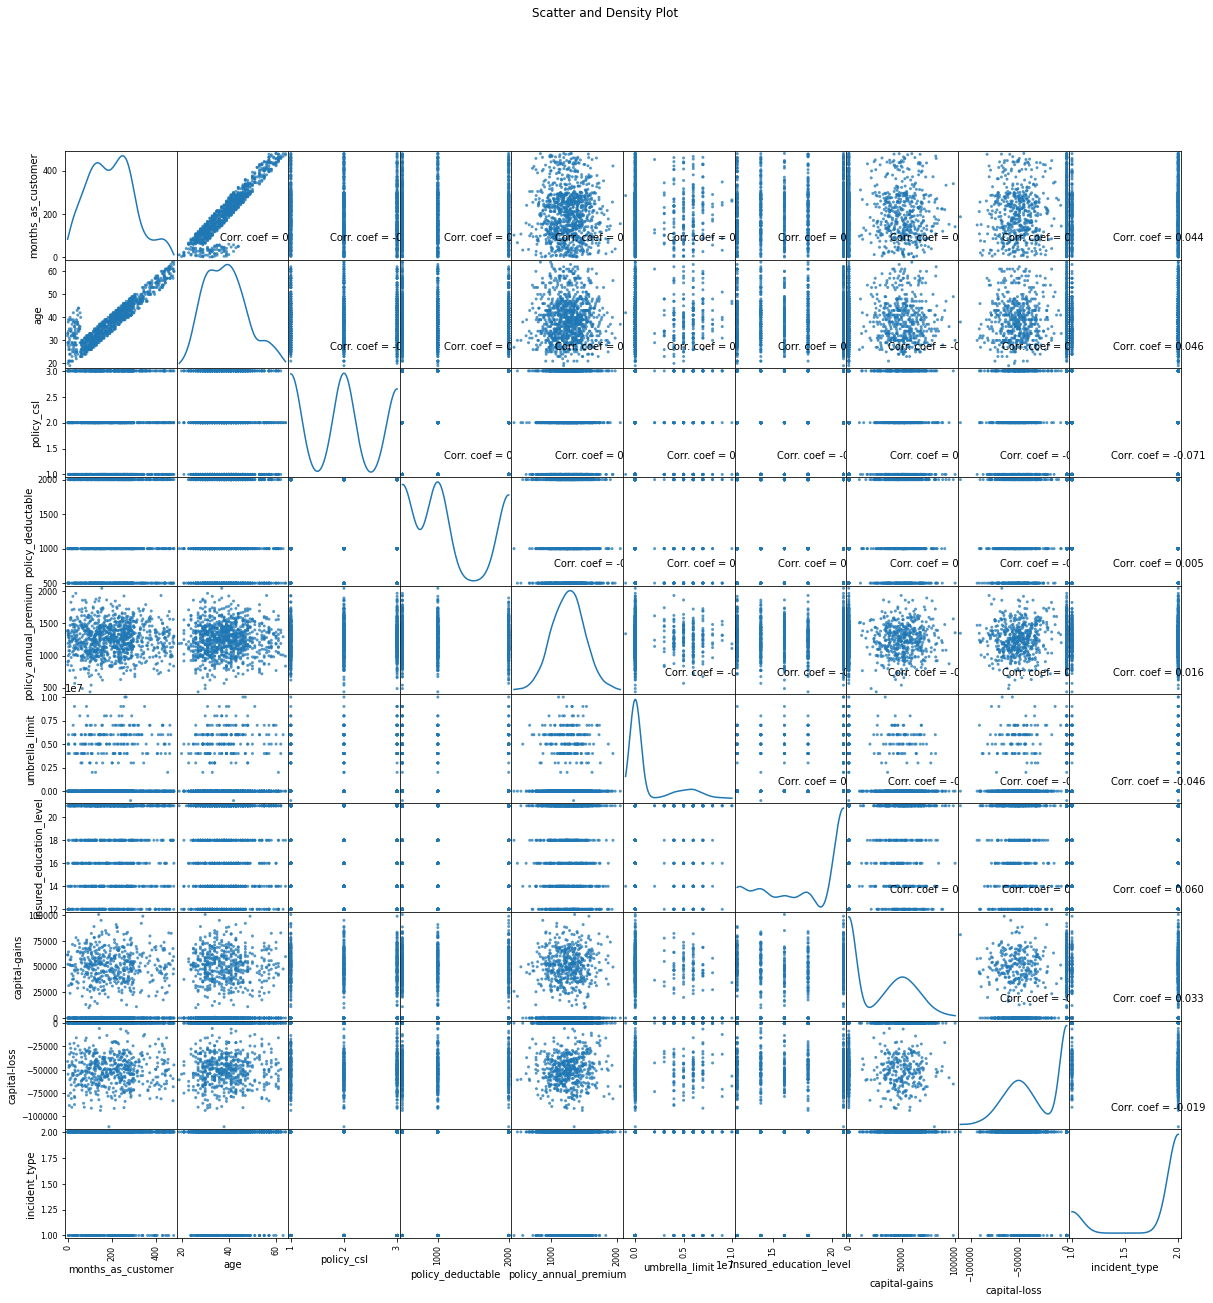

In [24]:
plotScatterMatrix(df, 20, 10)

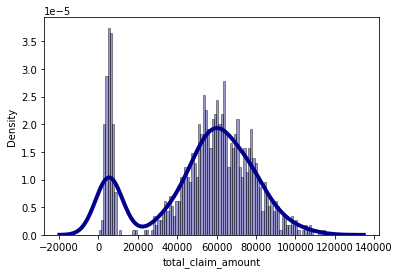

In [25]:
plotHistogram(df['total_claim_amount'])

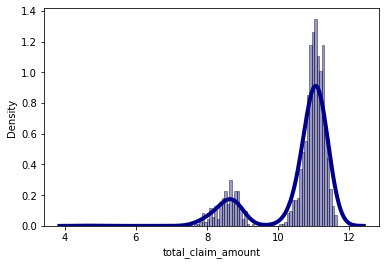

In [26]:
plotHistogram(np.log(df['total_claim_amount']))

In [27]:
df.loc[df['total_claim_amount'] < np.exp(9.55), 'claim_level'] = 1
df.loc[df['total_claim_amount'] >= np.exp(9.55), 'claim_level'] = 2

In [28]:
RATIO = 0.75 
SEED = 321 
df = pd.get_dummies(df)
X = df.drop(['claim_level','total_claim_amount'], axis=1)
Y = df['claim_level']
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = RATIO,
                                                    random_state = SEED, stratify=df['claim_level'])
def ClassificationModelPredict(classifier, title):
    model = classifier.fit(x_train, y_train)
    y_hat = model.predict(x_test)
    claim_level_predictions.loc[title, 'Accuracy Score']  = accuracy_score(y_test, y_hat)
claim_level_predictions = pd.DataFrame()

ClassificationModelPredict(LogisticRegression(), 'Logistic Regression')
ClassificationModelPredict(DecisionTreeClassifier(), 'Decision Tree')

print(claim_level_predictions)

                     Accuracy Score
Logistic Regression            0.82
Decision Tree                  1.00


In [29]:
LVC = df[df['claim_level'] == 1]
HVC = df[df['claim_level'] == 2]

In [30]:
def RegressionModel(regressor, title, stage):
  model = regressor.fit(x_train, y_train)
  scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_percentage_error', cv=5)
  regression_results.loc[title, stage] = np.abs(np.mean(scores))

In [31]:
RATIO = 0.7
SEED = 1234 
nRow, nCol = HVC.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 822 rows and 150 columns


In [ ]:
X = HVC.drop('total_claim_amount', axis=1).to_numpy()
Y = HVC['total_claim_amount'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(X, Y)
regression_results = pd.DataFrame()
stage = 'HVC'
RegressionModel(LinearRegression(),'Linear Regression', stage)
RegressionModel(DecisionTreeRegressor(), 'Decision Tree', stage)
RegressionModel(RandomForestRegressor(), 'Random Forest', stage)
RegressionModel(GradientBoostingRegressor(), 'Gradient Boost', stage)
RegressionModel(AdaBoostRegressor(), 'Ada Boost', stage)